In [3]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import yfinance as yf
pd.options.mode.chained_assignment = None

#pip install tensorflow

# Modelo de deep learning baseado no histórico recente (LSTM)

In [15]:
yf.pdr_override()
acao = "AAPL34.SA"

inicio = "2013-09-06"
final = "2023-08-27"

dados_acao = pdr.get_data_yahoo(acao, inicio, final)

dados_acao

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-06,2.045535,2.045535,2.040357,2.040000,1.778846,498400
2013-09-09,2.040357,2.040357,2.040357,2.040357,1.779158,0
2013-09-10,2.025535,2.025535,2.018750,2.010178,1.752842,750400
2013-09-11,1.892857,1.892857,1.892857,1.900000,1.656769,56000
2013-09-12,1.931250,1.931250,1.931250,1.917321,1.671872,1008000
...,...,...,...,...,...,...
2023-08-21,43.410000,43.919998,43.320000,43.650002,43.650002,166390
2023-08-22,43.669998,43.880001,43.509998,43.660000,43.660000,122955
2023-08-23,43.790001,44.279999,43.759998,44.049999,44.049999,146950


In [16]:
# nao pode ser ajustados
# treinar a cotação com um valor veridico: close (ajustado por desdobramento)
cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[ 2.03999996],
       [ 2.04035711],
       [ 2.01017809],
       ...,
       [44.04999924],
       [42.86000061],
       [43.45999908]])

In [17]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)
# treina 80% dos dados e testa o restante (20%)
# para evitar overfitting
tamanho_dados_treinamento

1982

In [18]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])
# no teste pode acontecer do valor ser maior q 1, nao tem problema
dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)
# é o mesmo array de cotação mas variando de 0 a 1
dados_entre_0_e_1

array([[0.00558007],
       [0.00558933],
       [0.00480607],
       ...,
       [1.09589929],
       [1.0650143 ],
       [1.08058655]])

In [19]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []

# pq 60?
# nosso modelo vai usar 60 dias para prever o preço da ação
# vai pegar os ultimos 60 dias e tentar prever o valor futuro para treinamento
for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.00558007, 0.00558933, 0.00480607, 0.00194653, 0.00239608,
       0.00275759, 0.        , 0.00024098, 0.00024098, 0.00024098,
       0.00024098, 0.00281318, 0.00281318, 0.0025722 , 0.00245632,
       0.00245632, 0.00245632, 0.00268806, 0.00240999, 0.00201604,
       0.00201604, 0.00201604, 0.00201604, 0.00201604, 0.00211801,
       0.00191409, 0.00191409, 0.00191409, 0.00191409, 0.00191409,
       0.00191409, 0.00191409, 0.00191409, 0.00549662, 0.00660431,
       0.00660431, 0.00660431, 0.00660431, 0.00570984, 0.00520002,
       0.00663675, 0.00691482, 0.00821716, 0.00787882, 0.00808274,
       0.00808274, 0.0085972 , 0.00818933, 0.00818933, 0.00818933,
       0.00762393, 0.00780929, 0.00777223, 0.00777223, 0.00777223,
       0.00777223, 0.01135479, 0.01133623, 0.01296299, 0.01272198])]
[0.014645342520222773]
[array([0.00558007, 0.00558933, 0.00480607, 0.00194653, 0.00239608,
       0.00275759, 0.        , 0.00024098, 0.00024098, 0.00024098,
       0.00024098, 0.00281318, 0.00

In [20]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)
print("\n2 dimenções\n")
print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)
print("\n3 dimenções\n")
print(treinamento_x)


2 dimenções

[[0.00558007 0.00558933 0.00480607 ... 0.01133623 0.01296299 0.01272198]
 [0.00558933 0.00480607 0.00194653 ... 0.01296299 0.01272198 0.01464534]
 [0.00480607 0.00194653 0.00239608 ... 0.01272198 0.01464534 0.01464534]
 ...
 [0.77549962 0.77666754 0.77368286 ... 0.97586296 0.95990142 0.96275626]
 [0.77666754 0.77368286 0.78030106 ... 0.95990142 0.96275626 0.95068783]
 [0.77368286 0.78030106 0.78575133 ... 0.96275626 0.95068783 0.98793148]]

3 dimenções

[[[0.00558007]
  [0.00558933]
  [0.00480607]
  ...
  [0.01133623]
  [0.01296299]
  [0.01272198]]

 [[0.00558933]
  [0.00480607]
  [0.00194653]
  ...
  [0.01296299]
  [0.01272198]
  [0.01464534]]

 [[0.00480607]
  [0.00194653]
  [0.00239608]
  ...
  [0.01272198]
  [0.01464534]
  [0.01464534]]

 ...

 [[0.77549962]
  [0.77666754]
  [0.77368286]
  ...
  [0.97586296]
  [0.95990142]
  [0.96275626]]

 [[0.77666754]
  [0.77368286]
  [0.78030106]
  ...
  [0.95990142]
  [0.96275626]
  [0.95068783]]

 [[0.77368286]
  [0.78030106]
  

In [21]:
#construindo o modelo
#ainda (obviamente) não foi treinado
modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

60

In [22]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [23]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
# batch_size é depois de quantas em quantas amostras o modelo irá otimizar os parametros
# epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo

# foi criado o mais simples possivel
modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1922/1922 [==============================] - 38s 18ms/step - loss: 0.0017


In [24]:
#criar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [25]:
#reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [26]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

16/16 [==============================] - 1s 13ms/step


array([[37.95575 ],
       [37.971153],
       [38.017967],
       [38.101055],
       [38.26051 ],
       [38.474876],
       [38.62148 ],
       [38.61139 ],
       [38.511234],
       [38.37773 ],
       [38.2309  ],
       [38.11304 ],
       [37.956272],
       [37.772472],
       [37.57915 ],
       [37.44761 ],
       [37.40113 ],
       [37.44136 ],
       [37.50709 ],
       [37.507973],
       [37.51247 ],
       [37.518215],
       [37.468563],
       [37.366405],
       [37.33669 ],
       [37.348415],
       [37.445034],
       [37.56523 ],
       [37.660534],
       [37.711765],
       [37.807594],
       [37.889694],
       [38.049026],
       [38.314312],
       [38.593918],
       [38.93301 ],
       [39.243195],
       [39.448357],
       [39.58673 ],
       [39.66934 ],
       [39.824894],
       [39.966972],
       [40.078728],
       [40.158627],
       [40.24331 ],
       [40.26035 ],
       [40.24075 ],
       [40.14752 ],
       [39.990833],
       [39.733097],


In [27]:
#pegando o erro médio quadrático (RMSE)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

1.8101626057778635

In [28]:
#criando o grafico do modelo


treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Close": dados_acao['Close'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


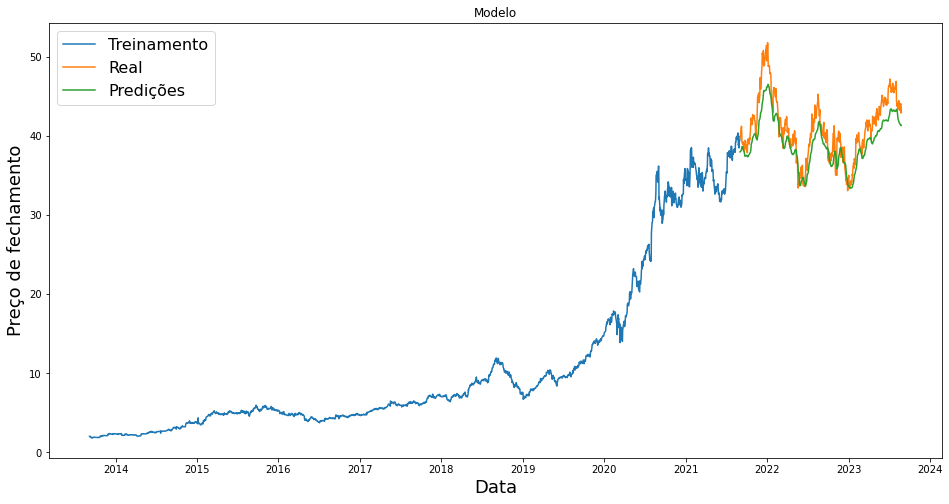

In [29]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [30]:
df_teste.sort_index()

df_teste

,Close,predicoes
Date,,
2021-09-01,39.625000,37.955750
2021-09-02,39.799999,37.971153
2021-09-03,40.070000,38.017967
2021-09-06,40.799999,38.101055
2021-09-08,41.200001,38.260509
...,...,...
2023-08-21,43.650002,41.429424
2023-08-22,43.660000,41.374180
2023-08-23,44.049999,41.342247


In [31]:
#o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Sera q isso foi feito?

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, 
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, 
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

,Close,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2021-09-02,39.799999,37.971153,0.004416,0.000406,True,True,True,0.004416
2021-09-03,40.070000,38.017967,0.006784,0.001233,True,True,True,0.006784
2021-09-06,40.799999,38.101055,0.018218,0.002185,True,True,True,0.018218
2021-09-08,41.200001,38.260509,0.009804,0.004185,True,True,True,0.009804
2021-09-09,40.404999,38.474876,-0.019296,0.005603,False,True,False,0.019296
...,...,...,...,...,...,...,...,...
2023-08-21,43.650002,41.429424,0.010183,-0.002358,True,False,False,0.010183
2023-08-22,43.660000,41.374180,0.000229,-0.001333,True,False,False,0.000229
2023-08-23,44.049999,41.342247,0.008933,-0.000772,True,False,False,0.008933


In [32]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

acertou_o_lado
False    0.015372
True     0.014196
Name: variacao_percentual_acao_abs, dtype: float64
0.9234845391197753
0.503030303030303
-0.04984997961561596


In [33]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

#data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    
#nao vai botar outra ação aqui hein kkkkkkkk
cotacoes = pdr.get_data_yahoo(acao, inicial, final) 
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 80ms/step
[[41.26169]]


# Sugestões:
<br>

- Melhorar as estatísticas de avaliação (dias seguidos ganhando, max DD, etc)
<br>

- Rodar pra todas as ações do ibovespa e criar uma expectativa matemática da expectativa matemática. Isso vai deixar o resultado final ainda mais robusto, definando a aloção do $ basedo na liquidez

In [34]:
dados_acao

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-06,2.045535,2.045535,2.040357,2.040000,1.778846,498400
2013-09-09,2.040357,2.040357,2.040357,2.040357,1.779158,0
2013-09-10,2.025535,2.025535,2.018750,2.010178,1.752842,750400
2013-09-11,1.892857,1.892857,1.892857,1.900000,1.656769,56000
2013-09-12,1.931250,1.931250,1.931250,1.917321,1.671872,1008000
...,...,...,...,...,...,...
2023-08-21,43.410000,43.919998,43.320000,43.650002,43.650002,166390
2023-08-22,43.669998,43.880001,43.509998,43.660000,43.660000,122955
2023-08-23,43.790001,44.279999,43.759998,44.049999,44.049999,146950


# -- esse é um teste de um código avulso!!!

In [35]:
# resample 'aapl' to business months, take last observation
monthly = dados_acao.resample('BM').apply(lambda x: x[-1])

# calculate the monthly percentage change
print(monthly.Close.pct_change())

# resample 'aapl' to quarters, take the mean as value per quarter
quarter = dados_acao.resample('4M').mean()

# calculate the quarterly percentage change
print(quarter.Close.pct_change())

Date
2013-09-30         NaN
2013-10-31    0.055070
2013-11-29    0.147681
2013-12-31    0.017515
2014-01-31   -0.083805
                ...   
2023-04-28    0.011005
2023-05-31    0.067203
2023-06-30    0.027051
2023-07-31    0.000648
2023-08-31   -0.062352
Freq: BM, Name: Close, Length: 120, dtype: float64
Date
2013-09-30         NaN
2014-01-31    0.139698
2014-05-31    0.033008
2014-09-30    0.219096
2015-01-31    0.286293
2015-05-31    0.363863
2015-09-30    0.067185
2016-01-31    0.047718
2016-05-31   -0.143831
2016-09-30   -0.083148
2017-01-31    0.107555
2017-05-31    0.198139
2017-09-30    0.091523
2018-01-31    0.122671
2018-05-31    0.084137
2018-09-30    0.339112
2019-01-31   -0.130461
2019-05-31    0.042716
2019-09-30    0.117698
2020-01-31    0.384213
2020-05-31    0.302552
2020-09-30    0.519190
2021-01-31    0.196594
2021-05-31    0.055996
2021-09-30    0.058054
2022-01-31    0.214303
2022-05-31   -0.107500
2022-09-30   -0.014531
2023-01-31   -0.069128
2023-05-31    0.111